In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
r = 0.02
S0 = 100      # spot price of the underlying stock today
K = 105       # strike at expiry
sigma = 0.25  # volatility
T = 2/12      # years to expiry
dT= 1/48      # T/numsteps = 1/48
numPaths = 10000  #sample size 
numSteps = 8  #8 weeks 

## 1. Monte Carlo Simulation

### a) 
1. Asian call 
2. Asian put 
3. Lookback call 
4. Lookback put 
5. Floating lookback call 
6. Floating lookback put 


Floating Lookbook Option Reference:

https://www.investopedia.com/terms/l/lookbackoption.asp

https://en.wikipedia.org/wiki/Lookback_option

In [17]:
paths = np.zeros((numSteps + 1, numPaths))    # array to store simulated paths
paths[0] = [S0] * numPaths

#Monte Carlo simulation of stock prices
for i in range(numPaths):
    for j in range(numSteps):
        paths[j+1, i] = paths[j, i] * np.exp((r - 0.5 * sigma**2) * dT + sigma * np.sqrt(dT) 
                                                         * np.random.normal(0,1))
        
        # paths[j+1, i] = paths[j, i] * np.exp((mu - 0.5 * sigma**2) * dT + sigma * np.sqrt(dT) 
        #                                                  * np.random.normal(0,1))

s_mean = paths.mean(axis=0)   #calculate mean price for each path 
s_min = paths.min(axis = 0)   #calculate mean price for each path 
s_max = paths.max(axis = 0)   #calculate mean price for each path 

#1) Asian Call
c_payoffT = np.maximum(s_mean[:] - K, 0)      #payoff for each path 
c = np.exp(-r * T) * np.mean(c_payoffT)       #mean of all path 
c_std = np.std(c_payoffT)                     #standard deviation of all path 


#2) Asian Put 
p_payoffT = np.maximum(K - s_mean[:], 0)      #payoff for each path 
p = np.exp(-r * T) * np.mean(p_payoffT)       #mean of all path 
p_std = np.std(p_payoffT)                     #standard deviation of all path 

#3) Lookback Call
lbc_payoffT = np.maximum(s_max[:] - K, 0)      #payoff for each path 
lbc = np.exp(-r * T) * np.mean(lbc_payoffT)    #mean of all path 
lbc_std = np.std(lbc_payoffT)                  #standard deviation of all path 

#4) Lookback Put 
lbp_payoffT = np.maximum(K - s_min[:], 0)      #payoff for each path 
lbp = np.exp(-r * T) * np.mean(lbp_payoffT)    #mean of all path 
lbp_std = np.std(lbp_payoffT)                  #standard deviation of all path 

#5) Floating Lookback call
flbc_payoffT = paths[-1, :] - s_min            #payoff for each path 
flbc = np.exp(-r * T) * np.mean(flbc_payoffT)  #mean of all path 
flbc_std = np.std(flbc_payoffT)                #standard deviation of all path 

#6) Floating Lookback put 
flbp_payoffT = s_max - paths[-1, :]             #payoff for each path 
flbp = np.exp(-r * T) * np.mean(flbp_payoffT)  #mean of all path 
flbp_std = np.std(flbp_payoffT)                #standard deviation of all path 

#display result 
option_name = ['Asian Call','Asian Put','Lookback Call','Lookback Put', 'Floating Lookback Call','Floating Lookback Put']
option_mean = [c, p, lbc, lbp, flbc, flbp]
option_std =  [c_std, p_std, lbc_std, lbp_std, flbc_std, flbp_std]

for i in range(len(option_mean)):
    print('The estimated price of {} is: {}'.format(option_name[i],round(option_mean[i],4)))
    print('The standard deviation of the estimated price is: {}'.format(round(option_std[i],4)))
    print('The 95% confidence interval of {} is: [{}, {}]'
          .format(option_name[i], round(option_mean[i]-1.96*option_std[i]/np.sqrt(numPaths),4),
                  round(option_mean[i]+1.96*option_std[i]/np.sqrt(numPaths),4)), '\n')
    

The estimated price of Asian Call is: 0.68
The standard deviation of the estimated price is: 1.9378
The 95% confidence interval of Asian Call is: [0.6421, 0.718] 

The estimated price of Asian Put is: 5.5107
The standard deviation of the estimated price is: 4.6176
The 95% confidence interval of Asian Put is: [5.4202, 5.6012] 

The estimated price of Lookback Call is: 3.3156
The standard deviation of the estimated price is: 5.3336
The 95% confidence interval of Lookback Call is: [3.2111, 3.4202] 

The estimated price of Lookback Put is: 10.9693
The standard deviation of the estimated price is: 5.5798
The 95% confidence interval of Lookback Put is: [10.8599, 11.0786] 

The estimated price of Floating Lookback Call is: 6.2692
The standard deviation of the estimated price is: 6.5453
The 95% confidence interval of Floating Lookback Call is: [6.1409, 6.3975] 

The estimated price of Floating Lookback Put is: 6.2437
The standard deviation of the estimated price is: 5.7461
The 95% confidence i

Text(0.5, 1.0, 'Geometric Random Paths of Monte Carlo Simulation for Stock Price')

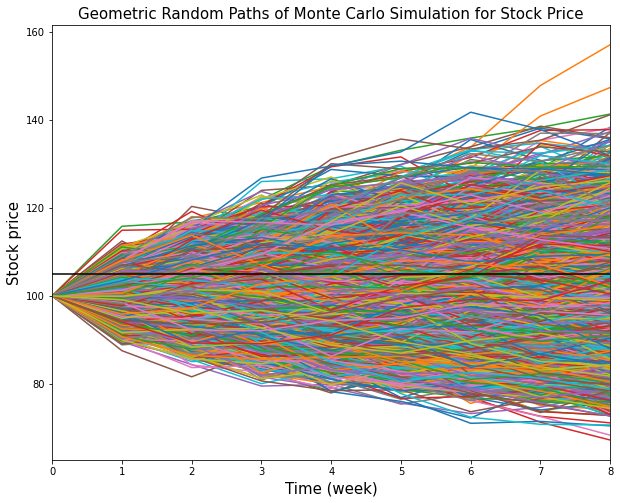

In [18]:
plt.figure(figsize = (10, 8))
plt.plot(paths[:,0:-1])
plt.axhline(K, c="k", xmin=0,xmax=numSteps, label="Strike Price")
plt.xlim([0, numSteps])
plt.xlabel("Time (week)", fontsize = 15)
plt.ylabel("Stock price", fontsize = 15)
plt.title('Geometric Random Paths of Monte Carlo Simulation for Stock Price', fontsize = 15)

### b) American Put Option

In [25]:
#American Put
st_list = []
ap_payoffT = [] 

from scipy.stats import norm
paths_ap = np.zeros((numSteps + 1, numPaths))    # array to store simulated paths
paths_ap[0] = [S0] * numPaths

for i in (range(numPaths)):
  st = None 

  for j in range(numSteps):
    t_r = T - j*dT               #time remaining of current simulation
        
    #simulate 
    S_now = paths_ap[j, i] * np.exp((r - 0.5 * (sigma**2)) * dT + sigma * np.sqrt(dT) 
                                                         * np.random.normal(0,1))
    paths_ap[j+1, i] = S_now
        
    #calculate d1 and d2
    if t_r != 0:
      d1 = (np.log(S_now/K) + ( r + 0.5 * (sigma**2))*t_r)/(sigma * np.sqrt(t_r))
      d2 = d1- (sigma * np.sqrt(t_r))
            
    else: 
      if S_now < K:
        d1 = -np.inf 
        d2 = d1 
      else: 
        d1 = np.inf
        d2 = d1
                
    put_premium = K * np.exp(-r * t_r) * norm.cdf(-d2,0,1) - S_now * norm.cdf(-d1, 0, 1)           #calculate premium
        
    payoff = np.maximum (K - S_now, 0)             #Calculate current payoff
        
    if payoff < put_premium:
      pass
        
    else: 
      st = j * dT     #if payoff >= put_premium, set current time step to be optimal stopping time and exit the simulation of current path 
      break 
        
  if st == None:
    st = T
    
  st_list.append(st)
  ap_payoffT.append(payoff * np.exp (-r*st))
    
ap_mean = np.mean(ap_payoffT)
ap_std = np.std (ap_payoffT)
st_list = [x/dT for x in st_list] #convert to weeks
st_mean = np.mean(st_list)
st_std = np.std(st_list)


In [27]:
print('\n')
print('The estimated price of American put option is: {}'.format(round(ap_mean,4)))
print('The standard deviation of the estimated price of American put option is: {}'.format(round(ap_std,4)))
print('The 95% confidence interval of American put option is: [{}, {}]'
      .format(round(ap_mean - 1.96 * ap_std/np.sqrt(numPaths),4),
                  round(ap_mean + 1.96 * ap_std/np.sqrt(numPaths),4)), '\n')

print('The estimated stop time is: {} week'.format(round(st_mean,4)))
print('The standard deviation of the estimated stop time is: {}'.format(round(st_std,4)))
print('The 95% confidence interval of stop time is: [{}, {}]'
      .format(round(st_mean - 1.96 * st_std/np.sqrt(numPaths),4),
                  round(st_mean + 1.96 * st_std/np.sqrt(numPaths),4)), '\n')



The estimated price of American put option is: 6.9298
The standard deviation of the estimated price of American put option is: 6.2226
The 95% confidence interval of American put option is: [6.8078, 7.0518] 

The estimated stop time is: 6.2522 week
The standard deviation of the estimated stop time is: 2.2336
The 95% confidence interval of stop time is: [6.2084, 6.296] 



## 2. Binomial Lattice 
### c) 
1. Asian call 
2. Asian put 
3. Lookback call 
4. Lookback put 
5. Floating lookback call 
6. Floating lookback put 

In [ ]:
u = np.exp(sigma*np.sqrt(dT))
d = 1 / u
R = np.exp(r*dT)
p = (R-d)/(u-d)
q = 1-p
paths = list(itertools.product([u, d], repeat=numSteps))
paths = [list(elem) for elem in paths]
for i in range(len(paths)):
    paths[i].insert(0,S0)
df = pd.DataFrame(paths)
df

,0,1,2,3,4,5,6,7,8
0,100,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743
1,100,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,0.964559
2,100,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,0.964559,1.036743
3,100,1.036743,1.036743,1.036743,1.036743,1.036743,1.036743,0.964559,0.964559
4,100,1.036743,1.036743,1.036743,1.036743,1.036743,0.964559,1.036743,1.036743
...,...,...,...,...,...,...,...,...,...
251,100,0.964559,0.964559,0.964559,0.964559,0.964559,1.036743,0.964559,0.964559
252,100,0.964559,0.964559,0.964559,0.964559,0.964559,0.964559,1.036743,1.036743
253,100,0.964559,0.964559,0.964559,0.964559,0.964559,0.964559,1.036743,0.964559
254,100,0.964559,0.964559,0.964559,0.964559,0.964559,0.964559,0.964559,1.036743


In [ ]:
df = df.cumprod(axis = 1)
df

,0,1,2,3,4,5,6,7,8
0,100.0,103.674334,107.483674,111.432983,115.527403,119.772265,124.173097,128.735631,133.465807
1,100.0,103.674334,107.483674,111.432983,115.527403,119.772265,124.173097,128.735631,124.173097
2,100.0,103.674334,107.483674,111.432983,115.527403,119.772265,124.173097,119.772265,124.173097
3,100.0,103.674334,107.483674,111.432983,115.527403,119.772265,124.173097,119.772265,115.527403
4,100.0,103.674334,107.483674,111.432983,115.527403,119.772265,115.527403,119.772265,124.173097
...,...,...,...,...,...,...,...,...,...
251,100.0,96.455889,93.037385,89.740037,86.559550,83.491784,86.559550,83.491784,80.532742
252,100.0,96.455889,93.037385,89.740037,86.559550,83.491784,80.532742,83.491784,86.559550
253,100.0,96.455889,93.037385,89.740037,86.559550,83.491784,80.532742,83.491784,80.532742
254,100.0,96.455889,93.037385,89.740037,86.559550,83.491784,80.532742,77.678572,80.532742


In [ ]:
paths_prob = list(itertools.product([p, q], repeat=numSteps))
paths_prob = [list(elem) for elem in paths_prob]
df_prob = pd.DataFrame(paths_prob)
df_prob

,0,1,2,3,4,5,6,7
0,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753
1,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.503247
2,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.503247,0.496753
3,0.496753,0.496753,0.496753,0.496753,0.496753,0.496753,0.503247,0.503247
4,0.496753,0.496753,0.496753,0.496753,0.496753,0.503247,0.496753,0.496753
...,...,...,...,...,...,...,...,...
251,0.503247,0.503247,0.503247,0.503247,0.503247,0.496753,0.503247,0.503247
252,0.503247,0.503247,0.503247,0.503247,0.503247,0.503247,0.496753,0.496753
253,0.503247,0.503247,0.503247,0.503247,0.503247,0.503247,0.496753,0.503247
254,0.503247,0.503247,0.503247,0.503247,0.503247,0.503247,0.503247,0.496753


In [ ]:
df_prob = df_prob.cumprod(axis = 1)
df_prob

,0,1,2,3,4,5,6,7
0,0.496753,0.246764,0.122581,0.060892,0.030249,0.015026,0.007464,0.003708
1,0.496753,0.246764,0.122581,0.060892,0.030249,0.015026,0.007464,0.003756
2,0.496753,0.246764,0.122581,0.060892,0.030249,0.015026,0.007562,0.003756
3,0.496753,0.246764,0.122581,0.060892,0.030249,0.015026,0.007562,0.003805
4,0.496753,0.246764,0.122581,0.060892,0.030249,0.015222,0.007562,0.003756
...,...,...,...,...,...,...,...,...
251,0.503247,0.253257,0.127451,0.064139,0.032278,0.016034,0.008069,0.004061
252,0.503247,0.253257,0.127451,0.064139,0.032278,0.016244,0.008069,0.004008
253,0.503247,0.253257,0.127451,0.064139,0.032278,0.016244,0.008069,0.004061
254,0.503247,0.253257,0.127451,0.064139,0.032278,0.016244,0.008175,0.004061


In [ ]:
means_paths = df.mean(axis=1)
# Asian Call
ac_payoff = means_paths - K
ac_payoff[ac_payoff<0] = 0
lattice_ac= np.exp(-r*T) * np.dot(ac_payoff, df_prob[7])

# Asian Put
ap_payoff = K - means_paths
ap_payoff[ap_payoff<0] = 0
lattice_ap = np.exp(-r*T) * np.dot(ap_payoff, df_prob[7])

In [ ]:
max_paths=df.max(axis=1)
min_paths=df.min(axis=1)
# Lookback call
lc_payoff = max_paths-K
lc_payoff[lc_payoff<0] = 0
lattice_lc = np.exp(-r*T) * np.dot(lc_payoff, df_prob[7])

# Lookback put
lp_payoff = K - min_paths
lp_payoff[lp_payoff<0] = 0
lattice_lp = np.exp(-r*T) * np.dot(lp_payoff, df_prob[7])

In [ ]:
S_maturity = df[8]
# Floating lookback call
flc_payoff = S_maturity - min_paths
flc_payoff[flc_payoff<0] = 0
lattice_flc = np.exp(-r*T) * np.dot(flc_payoff, df_prob[7])

# Floating lookback put
flp_payoff = max_paths-S_maturity
flp_payoff[flp_payoff<0] = 0
lattice_flp = np.exp(-r*T) * np.dot(flp_payoff, df_prob[7])

option_mean=[lattice_ac,lattice_ap,lattice_lc,lattice_lp,lattice_flc,lattice_flp]
option_name=['Asian call','Asian put','Lookback call','Lookback put',
            'Floating lookback call','Floating lookback put']

for i in range(6):
    print('The value of {0} is: {1}'.format(option_name[i],round(option_mean[i],4)))

The value of Asian call is: 0.6925
The value of Asian put is: 5.5095
The value of Lookback call is: 3.575
The value of Lookback put is: 11.2485
The value of Floating lookback call is: 6.5979
The value of Floating lookback put is: 6.5478


### d) American Put Option

In [ ]:
u = np.exp(sigma*np.sqrt(dT))
d = 1 / u
R = np.exp(r*dT)
p = (R-d)/(u-d)
q = 1-p

In [ ]:
#Using Recombinging tree:
earlypayoff ={}
for i in np.arange(8,-1,-1):
  earlypayoff[i] = []
  for k in range(i+1):
    earlypayoff[i].append(round(max(K - S0*(d**k)*(u**(i-k)),0),4))


In [ ]:
earlypayoff

{0: [5.0],
 1: [1.3257, 8.5441],
 2: [0, 5.0, 11.9626],
 3: [0, 1.3257, 8.5441, 15.26],
 4: [0, 0, 5.0, 11.9626, 18.4404],
 5: [0, 0, 1.3257, 8.5441, 15.26, 21.5082],
 6: [0, 0, 0, 5.0, 11.9626, 18.4404, 24.4673],
 7: [0, 0, 0, 1.3257, 8.5441, 15.26, 21.5082, 27.3214],
 8: [0, 0, 0, 0, 5.0, 11.9626, 18.4404, 24.4673, 30.0744]}

In [ ]:
# calculate the option value for each nodes at period 7
discounted = []
for i in range(8):
  discounted.append((p*earlypayoff[8][i] +q*earlypayoff[8][i+1])/R)
tempDF = pd.DataFrame()
tempDF['earlypayoff'] = earlypayoff[7]
tempDF['discounted'] = discounted
tempDF['max'] =tempDF.max(axis = 1)
tempDF['max']
tempDF

,earlypayoff,discounted,max
0,0.0000,0.000000,0.000000
1,0.0000,0.000000,0.000000
2,0.0000,0.000000,0.000000
3,1.3257,2.515185,2.515185
4,8.5441,8.500363,8.544100
5,15.2600,15.216190,15.260000
6,21.5082,21.464472,21.508200
7,27.3214,27.277686,27.321400


In [ ]:
# calculate the option value for each nodes for each period before period 7
for m in np.arange(6,-1,-1)+1 :
  discounted = []
  for i in range(m):
    discounted.append((p*tempDF['max'][i] +q*tempDF['max'][i+1])/R)
  tempDF = pd.DataFrame()
  tempDF['earlypayoff'] = earlypayoff[m-1]
  tempDF['discounted'] = discounted
  tempDF['max'] =tempDF.max(axis = 1)
  print("value at each nodes in period",m,"is \n",tempDF['max'])

value at each nodes in period 7 is 
 0     0.000000
1     0.000000
2     1.265231
3     5.546905
4    11.962600
5    18.440400
6    24.467300
Name: max, dtype: float64
value at each nodes in period 6 is 
 0     0.000000
1     0.636458
2     3.418544
3     8.771926
4    15.260000
5    21.508200
Name: max, dtype: float64
value at each nodes in period 5 is 
 0     0.320162
1     2.035685
2     6.110070
3    12.032013
4    18.440400
Name: max, dtype: float64
value at each nodes in period 4 is 
 0     1.183000
1     4.084404
2     9.086481
3    15.260000
Name: max, dtype: float64
value at each nodes in period 3 is 
 0     2.642021
1     6.598932
2    12.188205
Name: max, dtype: float64
value at each nodes in period 2 is 
 0    4.631393
1    9.407794
Name: max, dtype: float64
value at each nodes in period 1 is 
 0    7.03217
Name: max, dtype: float64


In [ ]:
print("American Put value is ",m,"is \n",tempDF['max'].values)

American Put value is  1 is 
 [7.03217038]
